In [1]:
# Necessary Packages
import networkx as nx

from networkx.generators.community import LFR_benchmark_graph

import matplotlib
import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors


from sklearn.metrics import normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

In [2]:
###
# Generate LFR graph
# import networkx as nx

# from networkx.generators.community import LFR_benchmark_graph
n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1 # Power-law exponent for the community size distribution 
            #S hould be >1
mu = 0.25 # Mixing parameter

G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=25, max_degree=100, min_community=50, max_community=100, 
    seed=2
)

# nx.draw(G, pos=nx.spring_layout(G),node_color='r', node_size=3, edge_color='b')  # Draw the graph generated above

In [3]:
G = nx.Graph(G) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G)) # a list of self loops

G.remove_edges_from(selfloop_edges) # Remove self-loops


In [4]:
# Get the intrinsic community structure as a list
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = {}
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break

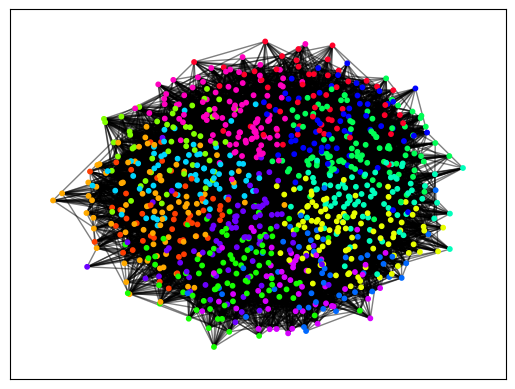

In [5]:
#import matplotlib
#import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      #intrinsic_membership.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(intrinsic_membership.values())
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [6]:
print(f"The network has {max(intrinsic_membership.values())+1} intrinsic communities.")

from community import community_louvain

louvain_membership = community_louvain.best_partition(G)

print(f"Louvain algorithm gives {max(louvain_membership.values())+1} communities.")

# Convert the NetworkX graph to an igraph graph
import igraph as ig
iG = ig.Graph.from_networkx(G)

# Perform Infomap clustering using igraph, and get the membership as a list
infomap_membership = list(iG.community_infomap().membership)
print(f"Infomap algorithm gives {max(infomap_membership)+1} communities.")


The network has 14 intrinsic communities.
Louvain algorithm gives 14 communities.
Infomap algorithm gives 14 communities.


In [7]:
intrinsic_clustering = Clustering(elm2clu_dict={i: [intrinsic_membership[i]] for i in intrinsic_membership.keys()})
louvain_clustering = Clustering(elm2clu_dict={i: [louvain_membership[i]] for i in louvain_membership.keys()})
infomap_clustering = Clustering(elm2clu_dict={i: [infomap_membership[i]] for i in range(len(infomap_membership))})

print(sim.element_sim(intrinsic_clustering, louvain_clustering, alpha=0.9),
      sim.element_sim(intrinsic_clustering, infomap_clustering, alpha=0.9),
      sim.element_sim(louvain_clustering, infomap_clustering, alpha=0.9)
     )


1.0 1.0 1.0


In [8]:
# Calculate NMIs
print(normalized_mutual_info_score(list(intrinsic_membership.values()), list(louvain_membership.values())),
      normalized_mutual_info_score(list(intrinsic_membership.values()), infomap_membership),
      normalized_mutual_info_score(infomap_membership, list(louvain_membership.values()))
     )
         #normalized_mutual_info_score(infomap_membership), list(louvain_membership.values())

1.0 1.0 0.9999999999999998


In [10]:
### Locally Linear 方法
from gem.embedding.lle import LocallyLinearEmbedding

for D in range(998, 32,-64):
    print(f"Processing {D}-dim case...")
    lle_model = LocallyLinearEmbedding(d=D)

    lle_embd = lle_model.learn_embedding(graph=G, is_weighted=False, no_python=True)
    print("Completed graph embedding")
    
    lle_vec = [Vectors.dense(row) for row in lle_embd]
    lle_prep = SparkSession.builder.getOrCreate().\
                        createDataFrame([(vector,) for vector in lle_vec], ["embd"])

    euclid_kmeans = KMeans(k=14, featuresCol="embd")
    cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
    lle_euclid_model = euclid_kmeans.fit(lle_prep)
    lle_cosine_model = cosine_kmeans.fit(lle_prep)

    # Add the cluster assignment to the DataFrame
    lle_euclid = lle_euclid_model.transform(lle_prep)
    lle_cosine = lle_cosine_model.transform(lle_prep)

    # Extract the cluster assignment and convert it to a list
    lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
    lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()
    print(max(lle_euclid_membership)+1, max(lle_cosine_membership)+1)

    # Calculate the NMI
    lle_euclid_nmi = normalized_mutual_info_score(list(lle_euclid_membership), list(intrinsic_membership.values()))
    lle_cosine_nmi = normalized_mutual_info_score(list(lle_cosine_membership), list(intrinsic_membership.values()))

    print(f"{D}-dimensional NMIs:", lle_euclid_nmi, lle_cosine_nmi)

    lle_euclid_clustering = Clustering(elm2clu_dict={i: [lle_euclid_membership[i]] for i in range(len(lle_euclid_membership))})
    lle_cosine_clustering = Clustering(elm2clu_dict={i: [lle_cosine_membership[i]] for i in range(len(lle_cosine_membership))})

    lle_euclid_similarity = sim.element_sim(intrinsic_clustering, lle_euclid_clustering, alpha=0.9)
    lle_cosine_similarity = sim.element_sim(intrinsic_clustering, lle_cosine_clustering, alpha=0.9)

    print(f"{D}-dimensional ECSim:", lle_euclid_similarity, lle_cosine_similarity)

Processing 998-dim case...
Completed graph embedding
14 14
998-dimensional NMIs: 0.024347832178431242 0.030353910689438986
998-dimensional ECSim: 0.07493800309103991 0.07551779630743562
Processing 934-dim case...
Completed graph embedding
14 14
934-dimensional NMIs: 0.02515992984988091 0.048741124286488455
934-dimensional ECSim: 0.07511864356366862 0.07827404782747982
Processing 870-dim case...
Completed graph embedding
14 14
870-dimensional NMIs: 0.02107335558769841 0.04522857619461069
870-dimensional ECSim: 0.07530761658309146 0.07638940971404182
Processing 806-dim case...
Completed graph embedding
14 14
806-dimensional NMIs: 0.03618771864194219 0.0511218182311452
806-dimensional ECSim: 0.0740146156861785 0.0796558936279507
Processing 742-dim case...
Completed graph embedding
14 14
742-dimensional NMIs: 0.037703954816542234 0.046345276865308
742-dimensional ECSim: 0.07361269574855867 0.07873982896061824
Processing 678-dim case...
Completed graph embedding
14 14
678-dimensional NMIs: 

In [9]:
### Hope 方法
from gem.embedding.hope import HOPE

for D in range(998, 32,-64):
    print(f"Processing {D}-dim case...")
    hope_model = HOPE(d=D, beta=0.01) 

    hope_embd = hope_model.learn_embedding(graph=G, is_weighted=False, no_python=True)
    print("Completed graph embedding")
    
    hope_vec = [Vectors.dense(row) for row in hope_embd]
    hope_prep = SparkSession.builder.getOrCreate().\
                        createDataFrame([(vector,) for vector in hope_vec], ["embd"])

    euclid_kmeans = KMeans(k=14, featuresCol="embd")
    cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
    hope_euclid_model = euclid_kmeans.fit(hope_prep)
    hope_cosine_model = cosine_kmeans.fit(hope_prep)

    # Add the cluster assignment to the DataFrame
    hope_euclid = hope_euclid_model.transform(hope_prep)
    hope_cosine = hope_cosine_model.transform(hope_prep)

    # Extract the cluster assignment and convert it to a list
    hope_euclid_membership = hope_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
    hope_cosine_membership = hope_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()
    print(max(hope_euclid_membership)+1, max(hope_cosine_membership)+1)

    # Calculate the NMI
    hope_euclid_nmi = normalized_mutual_info_score(list(hope_euclid_membership), list(intrinsic_membership.values()))
    hope_cosine_nmi = normalized_mutual_info_score(list(hope_cosine_membership), list(intrinsic_membership.values()))

    print(f"{D}-dimensional NMIs:", hope_euclid_nmi, hope_cosine_nmi)

    hope_euclid_clustering = Clustering(elm2clu_dict={i: [hope_euclid_membership[i]] for i in range(len(hope_euclid_membership))})
    hope_cosine_clustering = Clustering(elm2clu_dict={i: [hope_cosine_membership[i]] for i in range(len(hope_cosine_membership))})

    hope_euclid_similarity = sim.element_sim(intrinsic_clustering, hope_euclid_clustering, alpha=0.9)
    hope_cosine_similarity = sim.element_sim(intrinsic_clustering, hope_cosine_clustering, alpha=0.9)

    print(f"{D}-dimensional ECSim:", hope_euclid_similarity, hope_cosine_similarity)

Processing 998-dim case...
SVD error (low rank): 0.464274
Completed graph embedding


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/16 13:24:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/16 13:24:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/06/16 13:24:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


14 14
998-dimensional NMIs: 0.17022377936191777 0.9059120167278216
998-dimensional ECSim: 0.13394864440109966 0.7447717571930121
Processing 934-dim case...
SVD error (low rank): 0.513140
Completed graph embedding
14 14
934-dimensional NMIs: 0.5450167139883197 0.8546642774128144
934-dimensional ECSim: 0.26360109296736844 0.6253541907475241
Processing 870-dim case...
SVD error (low rank): 0.564418
Completed graph embedding
14 14
870-dimensional NMIs: 0.4241725963059051 0.7690496795639921
870-dimensional ECSim: 0.2683531786034879 0.49690781280447943
Processing 806-dim case...
SVD error (low rank): 0.618322
Completed graph embedding
14 14
806-dimensional NMIs: 0.4075451695267225 0.8444808366698933
806-dimensional ECSim: 0.24440862702065153 0.6120382899640042
Processing 742-dim case...
SVD error (low rank): 0.674373
Completed graph embedding
14 14
742-dimensional NMIs: 0.6574056485401352 0.8888333972972277
742-dimensional ECSim: 0.44340107382631877 0.6893241591080875
Processing 678-dim case

In [20]:
from node2vec import Node2Vec

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec_model = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=32) #, temp_folder='test' # Use temp_folder for big graphs
 
# Embed nodes 
node2vev_fit = node2vec_model.fit(window=10, min_count=1, batch_words=16)  
# Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
print("Embedding already generated!!")


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 32): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Embedding already generated!!


In [21]:
node2vec_embd=[]
for i in range(G.number_of_nodes()):
    node2vec_embd.append(node2vev_fit.wv[f'{i}'])
#node2vec_embd[:2]

In [23]:
D=64
node2vec_vec = [Vectors.dense(row) for row in node2vec_embd]
node2vec_prep = SparkSession.builder.getOrCreate().\
                    createDataFrame([(vector,) for vector in node2vec_vec], ["embd"])

euclid_kmeans = KMeans(k=14, featuresCol="embd")
cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
node2vec_euclid_model = euclid_kmeans.fit(node2vec_prep)
node2vec_cosine_model = cosine_kmeans.fit(node2vec_prep)

# Add the cluster assignment to the DataFrame
node2vec_euclid = node2vec_euclid_model.transform(node2vec_prep)
node2vec_cosine = node2vec_cosine_model.transform(node2vec_prep)

# Extract the cluster assignment and convert it to a list
node2vec_euclid_membership = node2vec_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
node2vec_cosine_membership = node2vec_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()
print(max(node2vec_euclid_membership)+1, max(node2vec_cosine_membership)+1)

# Calculate the NMI
node2vec_euclid_nmi = normalized_mutual_info_score(list(node2vec_euclid_membership), list(intrinsic_membership.values()))
node2vec_cosine_nmi = normalized_mutual_info_score(list(node2vec_cosine_membership), list(intrinsic_membership.values()))

print(f"{D}-dimensional NMIs:", node2vec_euclid_nmi, node2vec_cosine_nmi)

node2vec_euclid_clustering = Clustering(elm2clu_dict={i: [node2vec_euclid_membership[i]] for i in range(len(node2vec_euclid_membership))})
node2vec_cosine_clustering = Clustering(elm2clu_dict={i: [node2vec_cosine_membership[i]] for i in range(len(node2vec_cosine_membership))})

node2vec_euclid_similarity = sim.element_sim(intrinsic_clustering, node2vec_euclid_clustering, alpha=0.9)
node2vec_cosine_similarity = sim.element_sim(intrinsic_clustering, node2vec_cosine_clustering, alpha=0.9)

print(f"{D}-dimensional ECSim:", node2vec_euclid_similarity, node2vec_cosine_similarity)

14 14
64-dimensional NMIs: 0.9343132204273757 0.9754844669000687
64-dimensional ECSim: 0.7970386143910735 0.9088311688311689
